In [639]:
import sqlite3
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [640]:
RT_LIMIT_LOWER = 4340  # RT range in the database
RT_LIMIT_UPPER = 4580
RT_BASE_PEAK_WIDTH_SECS = 30.0  # assumption about base peak width in RT
RT_FRAGMENT_EVENT_DELTA_SECS = 3.5  # use this window for constraining RT to focus on the fragmentation event
MS1_CE = 10

In [641]:
BASE_NAME = "/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
BASE_MAXQUANT_TXT_DIR = '/Users/darylwilding-mcbride/Downloads/maxquant_results/txt'
ALLPEPTIDES_FILENAME = '{}/allPeptides.txt'.format(BASE_MAXQUANT_TXT_DIR)
PASEF_MSMS_SCANS_FILENAME = '{}/pasefMsmsScans.txt'.format(BASE_MAXQUANT_TXT_DIR)

# BASE_NAME = "/home/ubuntu/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
# ALLPEPTIDES_FILENAME = '/home/ubuntu/maxquant_results/txt/allPeptides.txt'

CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)

In [642]:
CONVERTED_DATABASE_NAME

'/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-4340-4580/HeLa_20KInt.sqlite'

In [643]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy == {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
ms2_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy <> {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
db_conn.close()

In [644]:
ms1_frame_properties_df.head()

,frame_id,retention_time_secs
0,40411,4340.340330
1,40422,4341.521415
2,40433,4342.702923
3,40444,4343.883324
4,40455,4345.067491


In [645]:
ms2_frame_properties_df.head()

,frame_id,retention_time_secs
0,40408,4340.019894
1,40409,4340.127084
2,40410,4340.233855
3,40412,4340.446655
4,40413,4340.554812


In [646]:
ms1_frame_delay = ms1_frame_properties_df.iloc[1].retention_time_secs - ms1_frame_properties_df.iloc[0].retention_time_secs
ms1_frame_delay

1.1810854877303427

In [647]:
len(ms1_frame_properties_df)

203

In [648]:
# get all the isolation windows
isolation_window_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/isolation_window_df.pkl')

In [649]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,CollisionEnergy,Precursor
0,3,507,532,742.744835,2.427448,36.96,1
1,3,549,574,709.235759,2.092358,36.96,2
2,3,602,627,594.235088,2.000000,36.96,3
3,3,643,668,503.527768,2.000000,36.96,4
4,3,684,709,552.063870,2.000000,31.92,5


In [650]:
# add-in the retention time for the isolation windows and filter out the window not in range
isolation_window_df = pd.merge(isolation_window_df, ms2_frame_properties_df, how='left', left_on=['Frame'], right_on=['frame_id'])
isolation_window_df.drop(['frame_id', 'CollisionEnergy'], axis=1, inplace=True)
isolation_window_df.dropna(subset=['retention_time_secs'], inplace=True)
isolation_window_df['mz_lower'] = isolation_window_df.IsolationMz - (isolation_window_df.IsolationWidth / 2) - 0.7
isolation_window_df['mz_upper'] = isolation_window_df.IsolationMz + (isolation_window_df.IsolationWidth / 2) + 0.7
isolation_window_df['wide_rt_lower'] = isolation_window_df.retention_time_secs - RT_BASE_PEAK_WIDTH_SECS
isolation_window_df['wide_rt_upper'] = isolation_window_df.retention_time_secs + RT_BASE_PEAK_WIDTH_SECS
isolation_window_df['fe_rt_lower'] = isolation_window_df.retention_time_secs - RT_FRAGMENT_EVENT_DELTA_SECS
isolation_window_df['fe_rt_upper'] = isolation_window_df.retention_time_secs + RT_FRAGMENT_EVENT_DELTA_SECS

In [651]:
# filter out isolation windows that don't fit in the database subset we have loaded
isolation_window_df = isolation_window_df[(isolation_window_df.wide_rt_lower >= RT_LIMIT_LOWER) & (isolation_window_df.wide_rt_upper <= RT_LIMIT_UPPER)]

In [652]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper,wide_rt_lower,wide_rt_upper,fe_rt_lower,fe_rt_upper
315657,40688,219,244,1106.675230,3.0,148941,4370.101926,1104.475230,1108.875230,4340.101926,4400.101926,4366.601926,4373.601926
315658,40688,287,312,987.488407,3.0,148938,4370.101926,985.288407,989.688407,4340.101926,4400.101926,4366.601926,4373.601926
315659,40688,344,369,922.491024,3.0,148930,4370.101926,920.291024,924.691024,4340.101926,4400.101926,4366.601926,4373.601926
315660,40688,386,411,884.941548,3.0,148942,4370.101926,882.741548,887.141548,4340.101926,4400.101926,4366.601926,4373.601926
315661,40688,434,459,876.400632,3.0,148943,4370.101926,874.200632,878.600632,4340.101926,4400.101926,4366.601926,4373.601926


### Select one of the isolation windows for analysis

In [653]:
print("There are {} precursor isolation windows.".format(len(isolation_window_df)))

There are 17860 precursor isolation windows.


In [654]:
# ISOLATION_WINDOW_IDX = 8089
# window_df = isolation_window_df.iloc[ISOLATION_WINDOW_IDX]

In [655]:
PRECURSOR_ID = 153421
window_df = isolation_window_df[isolation_window_df.Precursor == PRECURSOR_ID].iloc[0]

In [656]:
window_df

Frame                   41474.000000
ScanNumBegin              462.000000
ScanNumEnd                487.000000
IsolationMz               860.444362
IsolationWidth              3.000000
Precursor              153421.000000
retention_time_secs      4454.557286
mz_lower                  858.244362
mz_upper                  862.644362
wide_rt_lower            4424.557286
wide_rt_upper            4484.557286
fe_rt_lower              4451.057286
fe_rt_upper              4458.057286
Name: 324135, dtype: float64

In [657]:
mz_lower = window_df.mz_lower
mz_upper = window_df.mz_upper
scan_width = int(window_df.ScanNumEnd - window_df.ScanNumBegin)
wide_scan_lower = int(window_df.ScanNumBegin - scan_width)
wide_scan_upper = int(window_df.ScanNumEnd + scan_width)
fe_scan_lower = int(window_df.ScanNumBegin)
fe_scan_upper = int(window_df.ScanNumEnd)
wide_rt_lower = window_df.wide_rt_lower
wide_rt_upper = window_df.wide_rt_upper
fe_rt_lower = window_df.fe_rt_lower
fe_rt_upper = window_df.fe_rt_upper
precursor_id = int(window_df.Precursor)

In [658]:
# get the ms1 frame IDs
ms1_frame_ids = tuple(ms1_frame_properties_df.astype(int).values[:,0])


In [659]:
# load the cube's raw ms1 points
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(mz_lower, mz_upper, wide_scan_lower, wide_scan_upper, wide_rt_lower, wide_rt_upper, ms1_frame_ids), db_conn)
db_conn.close()

In [660]:
len(ms1_raw_points_df)

20794

In [661]:
ms1_raw_points_df.intensity.max()

1788

In [662]:
ms1_raw_points_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
0,41203,858.304358,469,9,4425.463095
1,41203,858.322836,511,47,4425.463095
2,41203,858.332075,443,10,4425.463095
3,41203,858.336695,445,72,4425.463095
4,41203,858.336695,449,63,4425.463095


In [663]:
ms1_raw_points_df.describe()

,frame_id,mz,scan,intensity,retention_time_secs
count,20794.000000,20794.000000,20794.000000,20794.000000,20794.000000
mean,41464.131240,859.932500,464.408050,87.869241,4453.494892
std,135.338354,1.193663,19.942714,148.292643,14.524340
min,41203.000000,858.248925,437.000000,9.000000,4425.463095
25%,41368.000000,858.928106,448.000000,32.000000,4443.177867
50%,41467.000000,859.667655,461.000000,54.000000,4453.805803
75%,41544.000000,860.860850,479.000000,81.000000,4462.064699
max,41753.000000,862.642931,512.000000,1788.000000,4484.495019


In [664]:
# get the raw points constrained to the fragmentation event's RT
fe_raw_points_df = ms1_raw_points_df[(ms1_raw_points_df.retention_time_secs >= fe_rt_lower) & (ms1_raw_points_df.retention_time_secs <= fe_rt_upper)]

In [665]:
fe_raw_points_df.to_csv('/Users/darylwilding-mcbride/Downloads/fe_raw_points_ms1.csv')

In [618]:
MZ_BIN_WIDTH = 0.1

In [619]:
ms1_bins = np.arange(start=mz_lower, stop=mz_upper+MZ_BIN_WIDTH, step=MZ_BIN_WIDTH)  # go slightly wider to accomodate the maximum value


In [620]:
# adjust the bins to illustrate the peak splitting issue
# ms1_bins += 0.06

In [621]:
MZ_BIN_COUNT = len(ms1_bins)

In [622]:
# initialise an array of lists to hold the m/z and intensity values allocated to each bin
ms1_mz_values_array = np.empty(MZ_BIN_COUNT, dtype=np.object)
for idx in range(MZ_BIN_COUNT):
    ms1_mz_values_array[idx] = []


In [623]:
%%time

# gather the m/z values into bins
for r in zip(fe_raw_points_df.mz, fe_raw_points_df.intensity):
    mz = r[0]
    intensity = int(r[1])
    if (mz >= mz_lower) and (mz <= mz_upper): # it should already but just to be sure
        mz_array_idx = int(np.digitize(mz, ms1_bins)) # in which bin should this mz go
        ms1_mz_values_array[mz_array_idx].append((mz, intensity))

CPU times: user 38.5 ms, sys: 16.7 ms, total: 55.1 ms
Wall time: 41.3 ms


In [624]:
import peakutils

In [625]:
%%time

# compute the intensity-weighted m/z centroid and the summed intensity of the bins
ms1_peaks = []
for bin_idx in range(MZ_BIN_COUNT):
    if len(ms1_mz_values_array[bin_idx]) > 0:
        mz_values_for_bin = np.array([ list[0] for list in ms1_mz_values_array[bin_idx]])
        intensity_values_for_bin = np.array([ list[1] for list in ms1_mz_values_array[bin_idx]]).astype(int)
        mz_centroid = peakutils.centroid(mz_values_for_bin, intensity_values_for_bin)
        summed_intensity = intensity_values_for_bin.sum()
        ms1_peaks.append((mz_centroid,summed_intensity))

CPU times: user 3.91 ms, sys: 786 µs, total: 4.7 ms
Wall time: 4.01 ms


In [626]:
ms1_peaks

[(858.3066489556553, 843),
 (858.4120324811556, 10591),
 (858.46634376448, 14446),
 (858.6087345569211, 643),
 (858.7002300476615, 2357),
 (858.7869569958199, 12416),
 (858.9356914530805, 269132),
 (858.9516466447012, 9940),
 (859.1208940486085, 8079),
 (859.1821062969926, 6982),
 (859.2946312248371, 2543),
 (859.4361960156403, 224788),
 (859.4490209647806, 31453),
 (859.6091632864104, 1429),
 (859.6853834084554, 4604),
 (859.7967688411497, 3364),
 (859.935393496842, 94665),
 (859.9472638620093, 42416),
 (860.1060037938984, 1260),
 (860.1913913896184, 916),
 (860.2983399986923, 1171),
 (860.4299517267889, 30129),
 (860.4482722652153, 24693),
 (860.6230286298403, 780),
 (860.7045773307269, 1005),
 (860.7701657549426, 3646),
 (860.9285217216856, 12664),
 (860.9605445323161, 6053),
 (861.0900519372763, 2870),
 (861.2006988183343, 454),
 (861.3011943777786, 379),
 (861.4159109889537, 6407),
 (861.4555748531699, 1900),
 (861.5979309210318, 934),
 (861.6800378620966, 1625),
 (861.78622924253

In [627]:
ms1_peaks_df = pd.DataFrame(ms1_peaks, columns=['mz_centroid','summed_intensity'])

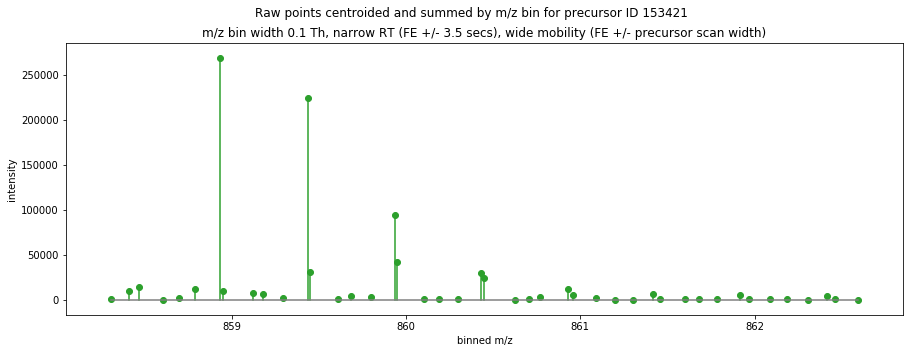

In [628]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(ms1_peaks_df.mz_centroid, ms1_peaks_df.summed_intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('binned m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Raw points centroided and summed by m/z bin for precursor ID {}'.format(precursor_id))
plt.title('m/z bin width {} Th, narrow RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MZ_BIN_WIDTH, RT_FRAGMENT_EVENT_DELTA_SECS))
plt.show()

Try the intensity descent approach instead of binning

In [666]:
len(fe_raw_points_df)

5560

In [667]:
fe_raw_points_df.intensity.max()

1788

In [631]:
MZ_TOLERANCE_PPM = 5
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

In [668]:
raw_scratch_df = fe_raw_points_df.copy() # take a copy because we're going to delete stuff
peaks_l = []
while len(raw_scratch_df) > 0:
    # find the most intense point
    peak_df = raw_scratch_df.loc[raw_scratch_df.intensity.idxmax()]
    mz = peak_df.mz
    mz_delta = mz * MZ_TOLERANCE_PERCENT / 100
    mz_lower = mz - mz_delta
    mz_upper = mz + mz_delta

    # get all the raw points within this m/z region
    peak_raw_points_df = raw_scratch_df[(raw_scratch_df.mz >= mz_lower) & (raw_scratch_df.mz <= mz_upper)]

    mz_centroid = peakutils.centroid(peak_raw_points_df.mz, peak_raw_points_df.intensity)
    summed_intensity = peak_raw_points_df.intensity.sum()
    peaks_l.append((mz_centroid, summed_intensity))

    # remove the raw points assigned to this peak
    raw_scratch_df = raw_scratch_df[~raw_scratch_df.isin(peak_raw_points_df)].dropna(how = 'all')


In [669]:
id_peaks_df = pd.DataFrame(peaks_l, columns=['mz','intensity'])

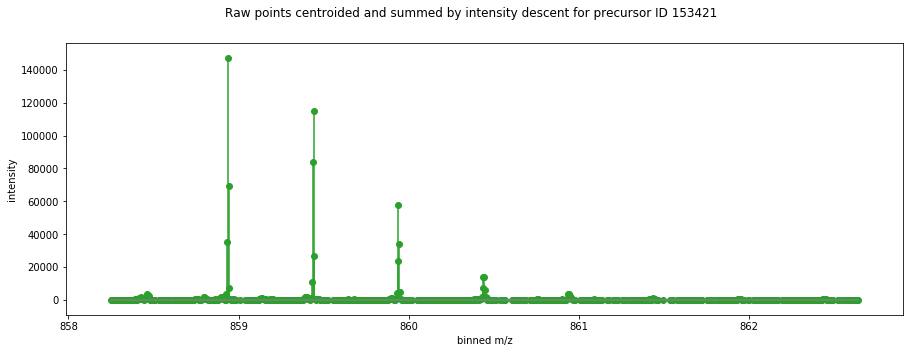

In [670]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(id_peaks_df.mz, id_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('binned m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Raw points centroided and summed by intensity descent for precursor ID {}'.format(precursor_id))
# plt.title('m/z bin width {} Th, narrow RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MZ_BIN_WIDTH, RT_FRAGMENT_EVENT_DELTA_SECS))
plt.show()

In [636]:
%%time

# see https://github.com/mobiusklein/ms_deisotope/blob/ee4b083ad7ab5f77722860ce2d6fdb751886271e/ms_deisotope/deconvolution/api.py#L17
deconvoluted_peaks, _priority_targets = deconvolute_peaks(peaks_l, averagine=averagine.peptide, charge_range=(1,5), scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)

CPU times: user 1min 1s, sys: 93.6 ms, total: 1min 1s
Wall time: 1min 1s


In [637]:
len(peaks_l)

935

### Deconvolute the raw (bin-summed, centroided) peaks to find monoisotopic peaks

In [511]:
PROTON_MASS = 1.0073  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.


In [512]:
from ms_deisotope import deconvolute_peaks, averagine, scoring

In [513]:
%%time

# see https://github.com/mobiusklein/ms_deisotope/blob/ee4b083ad7ab5f77722860ce2d6fdb751886271e/ms_deisotope/deconvolution/api.py#L17
deconvoluted_peaks, _priority_targets = deconvolute_peaks(ms1_peaks, averagine=averagine.peptide, charge_range=(1,5), scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)

CPU times: user 49 ms, sys: 1.87 ms, total: 50.8 ms
Wall time: 49.3 ms


In [514]:
peaks_l = []
for peak in deconvoluted_peaks:
    # discard a monoisotopic peak that has a second isotope with intensity of 1 (rubbish value)
    if ((len(peak.envelope) > 1) and (peak.envelope[1][1] > 1)):
        peaks_l.append((peak.mz, peak.neutral_mass, peak.intensity, peak.score, peak.signal_to_noise))
        print("{}\n".format(peak))

deconvoluted_peaks_df = pd.DataFrame(peaks_l, columns=['mz','neutral_mass','intensity','score','SN'])
# 'neutral mass' is the zero charge M, so we add the proton mass to get M+H (the monoisotopic mass)
deconvoluted_peaks_df['m_plus_h'] = deconvoluted_peaks_df.neutral_mass + PROTON_MASS


DeconvolutedPeak(a_to_a2_ratio=7.821728632160368, area=4710.0, average_mass=860.2444939248454, charge=1, chosen_for_msms=False, envelope=[(860.7559, 2759.38), (861.7477, 1053.00), (862.7613, 1.00)], full_width_at_half_max=0.01, index=2|7, intensity=3812.3822599466735, most_abundant_mass=859.7485979472101, mz=860.7558744139801, neutral_mass=859.7485979472101, score=59.66284355090838, signal_to_noise=2355.0)

DeconvolutedPeak(a_to_a2_ratio=7.821728632160368, area=878.0, average_mass=860.7364433387493, charge=1, chosen_for_msms=False, envelope=[(861.2415, 376.00), (862.2459, 502.00), (863.2470, 1.00)], full_width_at_half_max=0.01, index=3|12, intensity=878.0, most_abundant_mass=861.23866442863, mz=861.2414987156385, neutral_mass=860.2342222488685, score=23.015077460783722, signal_to_noise=439.0)

DeconvolutedPeak(a_to_a2_ratio=1.9308970182410141, area=19070.0, average_mass=1716.7942522238052, charge=2, chosen_for_msms=False, envelope=[(858.6583, 1637.00), (859.1487, 11888.00), (859.6576, 

In [515]:
deconvoluted_peaks_df

,mz,neutral_mass,intensity,score,SN,m_plus_h
0,860.755874,859.748598,3812.38226,59.662844,2355.00,860.755898
1,861.241499,860.234222,878.00000,23.015077,439.00,861.241522
2,858.647001,1715.279450,19070.00000,124.596435,4767.50,1716.286750
3,858.874223,1715.733892,32955.00000,269.319956,8238.75,1716.741192
4,858.938061,1715.861569,698553.00000,1546.497880,174638.25,1716.868869
5,859.254549,1716.494545,11161.00000,102.021324,2790.25,1717.501845
6,859.559462,1717.104371,2513.44551,39.039811,1056.75,1718.111671
7,860.869209,1719.723864,9324.00000,108.813632,2331.00,1720.731164
8,860.937996,1719.861440,31600.00000,188.352548,7900.00,1720.868740
9,861.056603,1720.098654,4559.00000,58.128048,1139.75,1721.105954


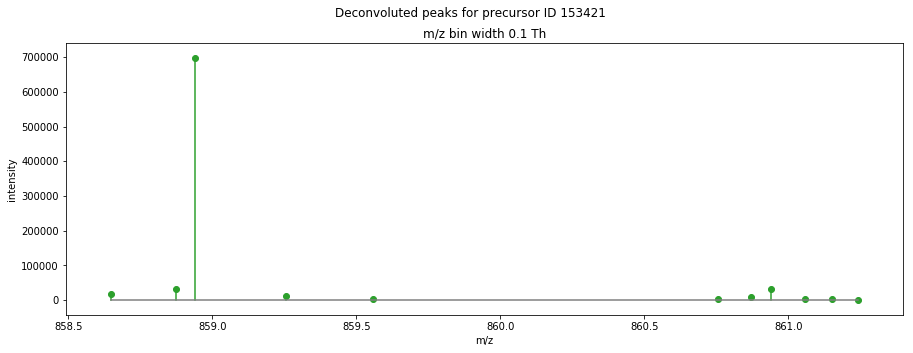

In [516]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(deconvoluted_peaks_df.mz, deconvoluted_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Deconvoluted peaks for precursor ID {}'.format(precursor_id))
plt.title('m/z bin width {} Th'.format(MZ_BIN_WIDTH))
plt.show()

### For each monoisotopic peak found, find its apex in RT and mobility

In [419]:
# picking one of the monoisotopic peaks for analysis
feature_monoisotopic_mz = deconvoluted_peaks_df.iloc[1].mz

In [420]:
feature_monoisotopic_mz

858.9345185967403

Get the raw points for the monoisotopic peak (constrained by the fragmentation event)

In [421]:
MZ_TOLERANCE_PPM = 20
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

In [422]:
monoisotopic_mz_ppm_tolerance = feature_monoisotopic_mz * MZ_TOLERANCE_PERCENT / 100
monoisotopic_mz_lower = feature_monoisotopic_mz - monoisotopic_mz_ppm_tolerance
monoisotopic_mz_upper = feature_monoisotopic_mz + monoisotopic_mz_ppm_tolerance

In [423]:
monoisotopic_raw_points_df = fe_raw_points_df[(fe_raw_points_df.mz >= monoisotopic_mz_lower) & (fe_raw_points_df.mz <= monoisotopic_mz_upper)]

In [424]:
monoisotopic_raw_points_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
4950,41445,858.946590,479,217,4451.447545
4951,41445,858.946590,495,60,4451.447545
4952,41445,858.951212,487,155,4451.447545
4953,41445,858.951212,489,52,4451.447545
4954,41445,858.951212,497,59,4451.447545


### Collapsing the monoisotopic's summed points onto the mobility dimension

In [425]:
scan_df = monoisotopic_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()

In [426]:
centroid_scan = peakutils.centroid(scan_df.scan, scan_df.intensity)

In [427]:
centroid_scan

482.51876019575855

In [428]:
feature_scan_centroid = centroid_scan
feature_scan_lower = window_df.ScanNumBegin
feature_scan_upper = window_df.ScanNumEnd

In [429]:
feature_scan_centroid, feature_scan_lower, feature_scan_upper

(482.51876019575855, 462.0, 487.0)

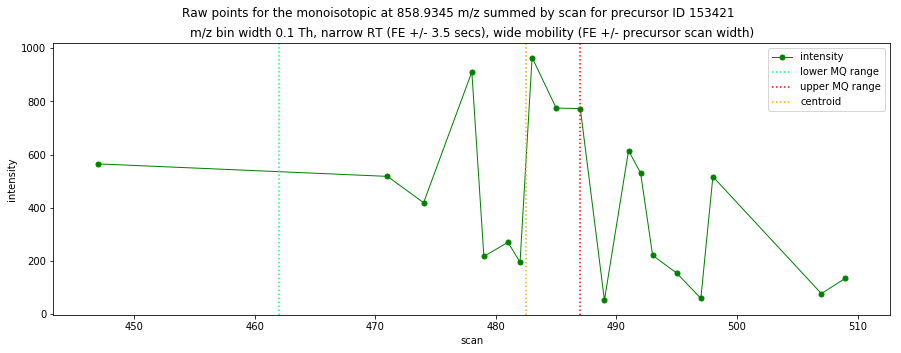

In [430]:
f, ax = plt.subplots()
ax.plot(scan_df.scan, scan_df.intensity, marker='o', color='green', linestyle='-', linewidth=1, ms=5)
plt.axvline(x=window_df.ScanNumBegin, linestyle=':', color='springgreen', label='lower MQ range')
plt.axvline(x=window_df.ScanNumEnd, linestyle=':', color='red', label='upper MQ range')
plt.axvline(x=centroid_scan, linestyle=':', color='orange', label='centroid')
plt.legend(loc='best')
plt.xlabel('scan')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points for the monoisotopic at {:.4f} m/z summed by scan for precursor ID {}'.format(feature_monoisotopic_mz, precursor_id))
plt.title('m/z bin width {} Th, narrow RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MZ_BIN_WIDTH, RT_FRAGMENT_EVENT_DELTA_SECS))
plt.margins(0.06)
plt.show()

### In the RT dimension, look wider to find the apex of the peak closest to the fragmentation event

In [431]:
wide_rt_monoisotopic_raw_points_df = ms1_raw_points_df[(ms1_raw_points_df.mz >= monoisotopic_mz_lower) & (ms1_raw_points_df.mz <= monoisotopic_mz_upper)]

In [432]:
len(wide_rt_monoisotopic_raw_points_df)

107

In [433]:
rt_df = wide_rt_monoisotopic_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()

In [434]:
peaks_threshold = 0.3
peaks_idx = peakutils.indexes(rt_df.intensity.values, thres=peaks_threshold, min_dist=10)
if len(peaks_idx) == 0:
    peaks_threshold -= 0.1
    peaks_idx = peakutils.indexes(rt_df.intensity.values, thres=peaks_threshold, min_dist=10)
peaks_df = rt_df.iloc[peaks_idx].copy()

In [435]:
peaks_df

,frame_id,retention_time_secs,intensity
21,41467,4453.805803,3182


In [436]:
peaks_df['fragmentation_rt_delta'] = abs(window_df.retention_time_secs - peaks_df.retention_time_secs)

In [437]:
peaks_df

,frame_id,retention_time_secs,intensity,fragmentation_rt_delta
21,41467,4453.805803,3182,0.751483


In [438]:
# get the peak closest to the fragmentation event
peaks_df.loc[peaks_df.fragmentation_rt_delta.idxmin()]

frame_id                  41467.000000
retention_time_secs        4453.805803
intensity                  3182.000000
fragmentation_rt_delta        0.751483
Name: 21, dtype: float64

In [439]:
# index of the closest peak
peak_idx = peaks_df.fragmentation_rt_delta.idxmin()
peak_idx

21

In [440]:
feature_rt_apex = peaks_df.loc[peak_idx].retention_time_secs

In [441]:
feature_rt_apex

4453.805803394633

In [442]:
valleys_idx = peakutils.indexes(-rt_df.intensity.values, thres=0.6, min_dist=RT_BASE_PEAK_WIDTH_SECS/20)
valleys_df = rt_df.iloc[valleys_idx].copy()

In [443]:
valleys_df

,frame_id,retention_time_secs,intensity
2,41258,4431.368938,48
4,41280,4433.733502,10
8,41324,4438.455780,30
10,41346,4440.816682,50
13,41379,4444.358407,70
15,41401,4446.722907,57
19,41445,4451.447545,543
23,41489,4456.163586,1159
29,41555,4463.244902,34
31,41577,4465.608514,126


In [444]:
valleys_idx

array([ 2,  4,  8, 10, 13, 15, 19, 23, 29, 31])

In [445]:
# find the closest valley above the peak
if max(valleys_idx) > peak_idx:
    valley_idx_above = valleys_idx[valleys_idx > peak_idx].min()
else:
    valley_idx_above = -1

In [446]:
# find the closest valley below the peak
if min(valleys_idx) < peak_idx:
    valley_idx_below = valleys_idx[valleys_idx < peak_idx].max()
else:
    valley_idx_below = -1

In [447]:
print("{},{}".format(valley_idx_below, valley_idx_above))

19,23


In [448]:
feature_rt_base_lower = valleys_df.loc[valley_idx_below].retention_time_secs
feature_rt_base_upper = valleys_df.loc[valley_idx_above].retention_time_secs

In [449]:
feature_rt_base_lower, feature_rt_base_upper

(4451.447545230602, 4456.1635864964965)

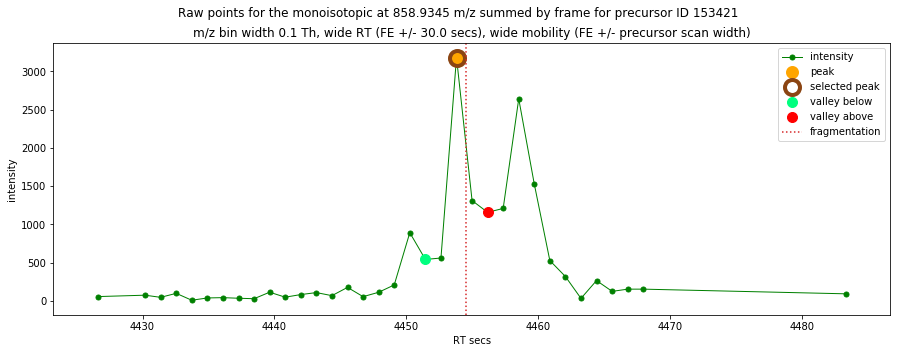

In [450]:
f, ax = plt.subplots()
ax.plot(rt_df.retention_time_secs, rt_df.intensity, marker='o', color='green', linestyle='-', linewidth=1, ms=5)
ax.plot(peaks_df.retention_time_secs, peaks_df.intensity, marker='o', color='orange', linestyle='', markeredgewidth=3, ms=10, label='peak')
ax.plot(peaks_df.loc[peak_idx].retention_time_secs, peaks_df.loc[peak_idx].intensity, marker='o', markerfacecolor='none', markeredgecolor='saddlebrown', linestyle='', markeredgewidth=4, ms=15, label='selected peak')
if valley_idx_below != -1:
    ax.plot(valleys_df.loc[valley_idx_below].retention_time_secs, valleys_df.loc[valley_idx_below].intensity, marker='o', color='springgreen', linestyle='', markeredgewidth=1, ms=10, label='valley below')
if valley_idx_above != -1:
    ax.plot(valleys_df.loc[valley_idx_above].retention_time_secs, valleys_df.loc[valley_idx_above].intensity, marker='o', color='red', linestyle='', markeredgewidth=1, ms=10, label='valley above')
plt.axvline(x=window_df.retention_time_secs, linestyle=':', color='tab:red', label='fragmentation')
plt.legend(loc='best')
plt.xlabel('RT secs')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points for the monoisotopic at {:.4f} m/z summed by frame for precursor ID {}'.format(feature_monoisotopic_mz, precursor_id))
plt.title('m/z bin width {} Th, wide RT (FE +/- {} secs), wide mobility (FE +/- precursor scan width)'.format(MZ_BIN_WIDTH, RT_BASE_PEAK_WIDTH_SECS))
plt.margins(0.06)
plt.show()

### Having extracted the MS1 feature characteristics, find all isolation windows that overlap with it

In [451]:
feature_monoisotopic_mz, feature_rt_apex, feature_rt_base_lower, feature_rt_base_upper, feature_scan_centroid, feature_scan_lower, feature_scan_upper

(858.9345185967403,
 4453.805803394633,
 4451.447545230602,
 4456.1635864964965,
 482.51876019575855,
 462.0,
 487.0)

In [452]:
# get all the isolation windows
isolation_window_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/isolation_window_df.pkl')

In [453]:
# add-in the retention time for the isolation windows and filter out the windows not in range
isolation_window_df = pd.merge(isolation_window_df, ms2_frame_properties_df, how='left', left_on=['Frame'], right_on=['frame_id'])

In [454]:
isolation_window_df.drop(['frame_id', 'CollisionEnergy'], axis=1, inplace=True)
isolation_window_df.dropna(subset=['retention_time_secs'], inplace=True)
isolation_window_df['mz_lower'] = isolation_window_df.IsolationMz - (isolation_window_df.IsolationWidth / 2)
isolation_window_df['mz_upper'] = isolation_window_df.IsolationMz + (isolation_window_df.IsolationWidth / 2)

In [455]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper
312803,40408,112,137,1135.738520,3.000000,147429,4340.019894,1134.238520,1137.238520
312804,40408,181,206,994.022363,3.000000,147430,4340.019894,992.522363,995.522363
312805,40408,263,288,1054.650881,3.000000,147451,4340.019894,1053.150881,1056.150881
312806,40408,324,349,789.368380,2.893684,147452,4340.019894,787.921538,790.815222
312807,40408,368,393,826.901660,3.000000,147453,4340.019894,825.401660,828.401660


In [456]:
# define the visualisation window
visualisation_mz_upper = feature_monoisotopic_mz + 3
visualisation_mz_lower = feature_monoisotopic_mz - 3
visualisation_scan_upper = feature_scan_upper + 20
visualisation_scan_lower = feature_scan_lower - 20
visualisation_rt_upper = feature_rt_base_upper
visualisation_rt_lower = feature_rt_base_lower

In [457]:
# find the isolation windows visible in the visualisation window
indexes = isolation_window_df.index[
                        (
                            ((isolation_window_df.mz_lower >= visualisation_mz_lower) &
                             (isolation_window_df.mz_lower <= visualisation_mz_upper)) |
                            ((isolation_window_df.mz_upper >= visualisation_mz_lower) &
                            (isolation_window_df.mz_upper <= visualisation_mz_upper))
                        ) &
                        (
                            ((isolation_window_df.ScanNumBegin >= visualisation_scan_lower) &
                             (isolation_window_df.ScanNumBegin <= visualisation_scan_upper)) |
                            ((isolation_window_df.ScanNumEnd >= visualisation_scan_lower) &
                            (isolation_window_df.ScanNumEnd <= visualisation_scan_upper))
                        ) &
                        (isolation_window_df.retention_time_secs >= visualisation_rt_lower) &
                        (isolation_window_df.retention_time_secs <= visualisation_rt_upper)
                       ]
isolation_windows_in_visualisation_area_df = isolation_window_df.loc[indexes]

In [458]:
isolation_windows_in_visualisation_area_df

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper
324135,41474,462,487,860.444362,3.0,153421,4454.557286,858.944362,861.944362


In [459]:
feature_monoisotopic_mz

858.9345185967403

In [460]:
feature_rt_base_lower, feature_rt_base_upper

(4451.447545230602, 4456.1635864964965)

In [461]:
feature_scan_centroid

482.51876019575855

In [462]:
# find the isolation windows overlapping the feature's characteristics
indexes = isolation_window_df.index[
                            (isolation_window_df.mz_upper >= feature_monoisotopic_mz) &
                            (isolation_window_df.mz_lower <= feature_monoisotopic_mz) &
                            (isolation_window_df.ScanNumEnd >= feature_scan_centroid) &
                            (isolation_window_df.ScanNumBegin <= feature_scan_centroid) &
                            (isolation_window_df.retention_time_secs >= feature_rt_base_lower) &
                            (isolation_window_df.retention_time_secs <= feature_rt_base_upper)
                       ]
isolation_windows_overlapping_feature_df = isolation_window_df.loc[indexes]

In [463]:
isolation_windows_overlapping_feature_df

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper


In [352]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

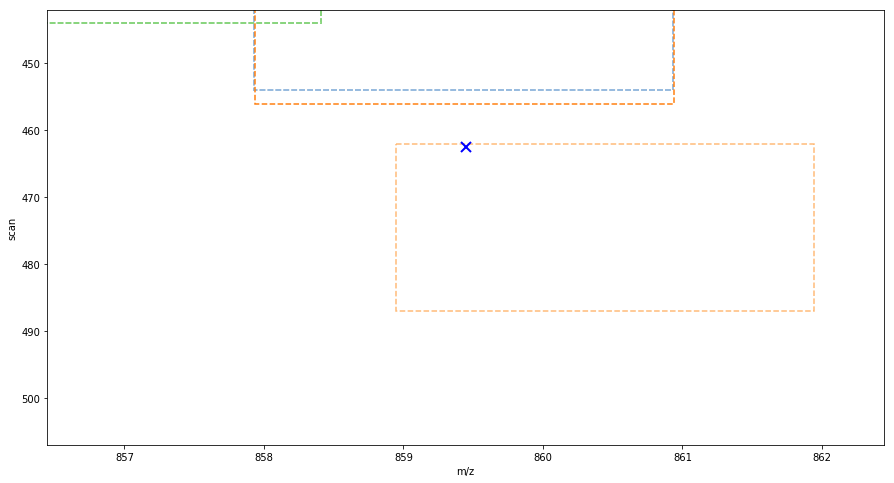

In [353]:
import matplotlib.patches as patches

f, ax1 = plt.subplots()

# add the mono peak's centroid
plt.plot(feature_monoisotopic_mz, feature_scan_centroid, 'bx', ms=10, mew=2, label='centroid')

# add isolation windows matched
for idx in range(len(isolation_windows_in_visualisation_area_df)):
    window = isolation_windows_in_visualisation_area_df.iloc[idx]
    drift_range = window.ScanNumEnd - window.ScanNumBegin
    mz_range = window.mz_upper - window.mz_lower
    isolation_window_rect = patches.Rectangle((window.mz_lower,window.ScanNumBegin),mz_range,drift_range,linewidth=1.5,linestyle='--',edgecolor=tableau20[idx%len(tableau20)],facecolor='none')
    ax1.add_patch(isolation_window_rect)
    text_style = dict(size=12, color=tableau20[idx%len(tableau20)])
#     ax1.text(window.mz_lower, window.ScanNumBegin-0.5, window.frame_precursor, **text_style)
    
f.set_figheight(8)
f.set_figwidth(15)
# plt.gca().invert_yaxis()
plt.gca().set_xlim([visualisation_mz_lower,visualisation_mz_upper])
plt.gca().set_ylim([visualisation_scan_upper,visualisation_scan_lower])
plt.xlabel('m/z')
plt.ylabel('scan')
# plt.legend(loc='best')
plt.margins(0.02)
# plt.suptitle("Feature {} and isolation window overlap, RT={} to {}".format(feature_id_of_interest, round(feature.feature_start_rt,1), round(feature.feature_end_rt,1)))
# plt.title('{}'.format(feature_list_filename))
plt.show()

### Extract the raw ms2 points from these isolation windows

In [354]:
# get the ms2 frame IDs
ms2_frame_ids = tuple(ms2_frame_properties_df.astype(int).values[:,0])


In [355]:
isolation_window_scan_lower = int(isolation_windows_overlapping_feature_df.iloc[0].ScanNumBegin)
isolation_window_scan_upper = int(isolation_windows_overlapping_feature_df.iloc[0].ScanNumEnd)
isolation_window_frame_id = int(isolation_windows_overlapping_feature_df.iloc[0].Frame)

In [356]:
isolation_window_scan_lower, isolation_window_scan_upper, isolation_window_frame_id

(462, 487, 41474)

In [357]:
# get the raw ms2 points from the fragmentation frame within the scan constraints
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms2_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where scan >= {} and scan <= {} and frame_id == {}".format(isolation_window_scan_lower, isolation_window_scan_upper, isolation_window_frame_id), db_conn)
db_conn.close()

In [358]:
len(ms2_raw_points_df)

1575

In [359]:
MS2_MZ_MAX = ms2_raw_points_df.mz.max()
MS2_MZ_MIN = ms2_raw_points_df.mz.min()

In [360]:
MS2_MZ_MIN, MS2_MZ_MAX

(154.84300242408736, 1686.899942827893)

In [361]:
ms2_bins = np.arange(start=MS2_MZ_MIN, stop=MS2_MZ_MAX+MZ_BIN_WIDTH, step=MZ_BIN_WIDTH)  # go slightly wider to accomodate the maximum value


In [362]:
MS2_MZ_BIN_COUNT = len(ms2_bins)

In [363]:
# initialise an array of lists to hold the m/z and intensity values allocated to each bin
ms2_mz_values_array = np.empty(MS2_MZ_BIN_COUNT, dtype=np.object)
for idx in range(MS2_MZ_BIN_COUNT):
    ms2_mz_values_array[idx] = []


In [364]:
%%time

# gather the m/z values into bins
for r in zip(ms2_raw_points_df.mz, ms2_raw_points_df.intensity):
    mz = r[0]
    intensity = int(r[1])
    if (mz >= MS2_MZ_MIN) and (mz <= MS2_MZ_MAX): # it should already but just to be sure
        mz_array_idx = int(np.digitize(mz, ms2_bins)) # in which bin should this mz go
        ms2_mz_values_array[mz_array_idx].append((mz, intensity))

CPU times: user 26.9 ms, sys: 1.48 ms, total: 28.4 ms
Wall time: 33.9 ms


In [365]:
%%time

# compute the intensity-weighted m/z centroid and the summed intensity of the bins
ms2_peaks = []
for bin_idx in range(MS2_MZ_BIN_COUNT):
    if len(ms2_mz_values_array[bin_idx]) > 0:
        mz_values_for_bin = np.array([ list[0] for list in ms2_mz_values_array[bin_idx]])
        intensity_values_for_bin = np.array([ list[1] for list in ms2_mz_values_array[bin_idx]]).astype(int)
        mz_centroid = peakutils.centroid(mz_values_for_bin, intensity_values_for_bin)
        summed_intensity = intensity_values_for_bin.sum()
        if summed_intensity > 6500:
            print(bin_idx)
            print(intensity_values_for_bin)
            print(intensity_values_for_bin.sum())
        ms2_peaks.append((mz_centroid,summed_intensity))

4575
[337 490 287  80 287  40 258 249 582 332 220 150 237 199 183 312  75 206
 243 378 108 112  57 226 217 136 309  80  57  85 156]
6688
CPU times: user 26.5 ms, sys: 5.96 ms, total: 32.5 ms
Wall time: 27.6 ms


In [366]:
df = pd.DataFrame(ms2_mz_values_array[4575], columns=['mz','intensity'])

In [367]:
df.sort_values(by=['mz'], ascending=False)

,mz,intensity
14,612.323715,183
22,612.319813,57
0,612.315911,337
27,612.315911,80
26,612.312010,309
24,612.312010,217
19,612.312010,378
17,612.312010,206
1,612.312010,490
30,612.312010,156


In [368]:
df.intensity.sum()

6688

In [369]:
df.groupby('mz').intensity.mean().sum()

1545.8757575757577

In [370]:
df.to_csv('/Users/darylwilding-mcbride/Downloads/example_bin_4575.csv')

In [371]:
df = ms2_raw_points_df[(ms2_raw_points_df.mz >= 612.308) & (ms2_raw_points_df.mz <= 612.309)]
df

,frame_id,mz,scan,intensity,retention_time_secs
176,41474,612.308108,464,287,4454.557286
258,41474,612.308108,465,287,4454.557286
416,41474,612.308108,467,249,4454.557286
552,41474,612.308108,469,332,4454.557286
628,41474,612.308108,470,220,4454.557286
692,41474,612.308108,471,150,4454.557286
819,41474,612.308108,473,199,4454.557286
894,41474,612.308108,474,312,4454.557286
1023,41474,612.308108,476,243,4454.557286
1246,41474,612.308108,480,226,4454.557286


In [372]:
df.intensity.sum()

2562

In [373]:
len(ms2_peaks)

678

In [374]:
ms2_peaks_df = pd.DataFrame(ms2_peaks, columns=['mz','intensity'])

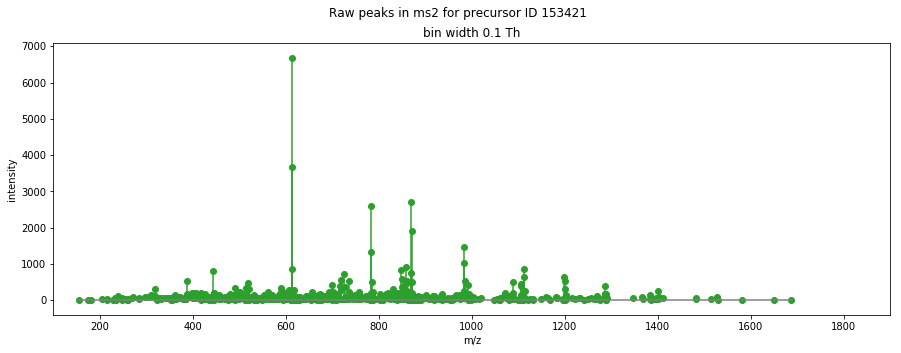

In [375]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(ms2_peaks_df.mz, ms2_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
ax.set_xlim((100,1900))
plt.margins(0.06)
plt.suptitle('Raw peaks in ms2 for precursor ID {}'.format(precursor_id))
plt.title('bin width {} Th'.format(MZ_BIN_WIDTH))
plt.show()

In [376]:
%%time

# ms2_deconvoluted_peaks, _ = deconvolute_peaks(ms2_peaks, averagine=averagine.peptide, charge_range=(1,5), scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)
ms2_deconvoluted_peaks, _ = deconvolute_peaks(ms2_peaks, averagine=averagine.peptide, charge_range=(1,5), scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)

CPU times: user 331 ms, sys: 4.12 ms, total: 335 ms
Wall time: 335 ms


In [377]:
ms2_peaks_l = []
for peak in ms2_deconvoluted_peaks:
    # discard a monoisotopic peak that has a second isotope with intensity of 1 (rubbish value)
    if ((len(peak.envelope) > 1) and (peak.envelope[1][1] > 1)):
        ms2_peaks_l.append((peak.mz, peak.charge, peak.neutral_mass, peak.intensity, peak.score, peak.signal_to_noise))
        print("{}\n".format(peak))

ms2_deconvoluted_peaks_df = pd.DataFrame(ms2_peaks_l, columns=['mz','charge','neutral_mass','intensity','score','SN'])
# 'neutral mass' is the zero charge M, so we add the proton mass to get M+H (the monoisotopic mass)
ms2_deconvoluted_peaks_df['m_plus_h'] = ms2_deconvoluted_peaks_df.neutral_mass + PROTON_MASS


DeconvolutedPeak(a_to_a2_ratio=0.0, area=434.0, average_mass=317.6739006769863, charge=1, chosen_for_msms=False, envelope=[(318.1818, 315.00), (319.1806, 119.00)], full_width_at_half_max=0.01, index=1|1, intensity=434.0, most_abundant_mass=317.1744823999862, mz=318.1817588667562, neutral_mass=317.1744823999862, score=20.483664404011243, signal_to_noise=217.0)

DeconvolutedPeak(a_to_a2_ratio=0.0, area=703.0, average_mass=386.6971117152199, charge=1, chosen_for_msms=False, envelope=[(387.1995, 531.00), (388.2093, 172.00)], full_width_at_half_max=0.01, index=2|2, intensity=703.0, most_abundant_mass=386.1922048729834, mz=387.1994813397534, neutral_mass=386.1922048729834, score=27.818602552488993, signal_to_noise=351.5)

DeconvolutedPeak(a_to_a2_ratio=0.0, area=174.0, average_mass=485.71228105060027, charge=1, chosen_for_msms=False, envelope=[(486.2191, 133.00), (487.2200, 41.00)], full_width_at_half_max=0.01, index=12|12, intensity=174.0, most_abundant_mass=485.21179610305336, mz=486.21907

In [378]:
len(ms2_deconvoluted_peaks_df)

72

In [379]:
ms2_deconvoluted_peaks_df.mz.min(),ms2_deconvoluted_peaks_df.mz.max()

(318.1817588667562, 1285.6493626767317)

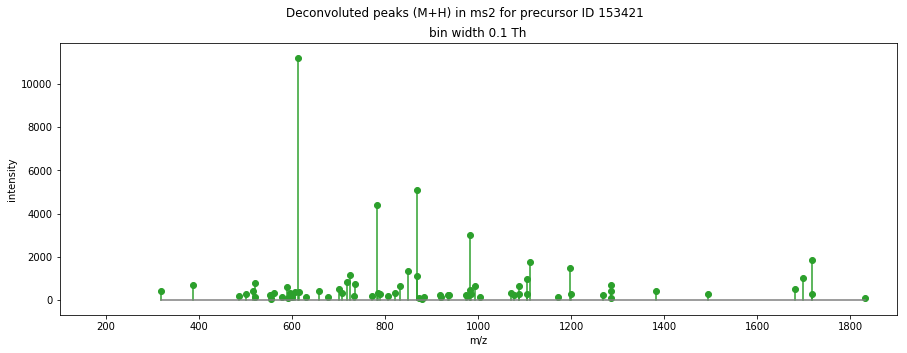

In [380]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(ms2_deconvoluted_peaks_df.m_plus_h, ms2_deconvoluted_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
ax.set_xlim((100,1900))
plt.margins(0.06)
plt.suptitle('Deconvoluted peaks (M+H) in ms2 for precursor ID {}'.format(precursor_id))
plt.title('bin width {} Th'.format(MZ_BIN_WIDTH))
plt.show()

In [381]:
ms2_deconvoluted_peaks_df[['mz','intensity']].to_csv('/Users/darylwilding-mcbride/Downloads/my_ms2_for_precursor_{}.csv'.format(precursor_id))

In [382]:
# find the top peaks by intensity
ms2_deconvoluted_peaks_df.sort_values(by=['intensity'], ascending=False).head(10)

,mz,charge,neutral_mass,intensity,score,SN,m_plus_h
16,612.308324,1,611.301048,11211.000000,131.817595,3737.000000,612.308348
36,869.450873,1,868.443596,5098.000000,97.503832,1699.333333,869.450896
28,782.415036,1,781.407760,4413.000000,89.915569,1471.000000,782.415060
46,982.523469,1,981.516192,3020.000000,72.456131,1006.666667,982.523492
69,859.425530,2,1716.836508,1869.000000,60.539867,467.250000,1717.843808
57,1111.571713,1,1110.564436,1777.000000,56.179265,592.333333,1111.571736
59,1198.600970,1,1197.593693,1491.000000,45.903135,497.000000,1198.600993
34,848.409669,1,847.402393,1360.253758,46.656902,584.000000,848.409693
24,725.390912,1,724.383635,1185.000000,48.060059,395.000000,725.390935
35,869.436769,1,868.429492,1108.000000,36.569553,369.333333,869.436792


### Compare with the ms2 spectra recorded by MaxQuant in the APL files

In [383]:
pasef_msms_scans_df = pd.read_csv(PASEF_MSMS_SCANS_FILENAME, sep='\t')

In [384]:
pasef_msms_scans_df.head()

,Raw file,Frame,Precursor,IsolationMz,IsolationWidth,ScanNumBegin,ScanNumEnd,CollisionEnergy,Index
0,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,1,742.744835,2.427448,507,532,36.96,0
1,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,2,709.235759,2.092358,549,574,36.96,1
2,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,3,594.235088,2.000000,602,627,36.96,2
3,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,4,503.527768,2.000000,643,668,36.96,3
4,HeLa_20KInt_2KIT_Slot1-46_01_1179,3,5,552.063870,2.000000,684,709,31.92,4


In [385]:
pasef_msms_scans_df[pasef_msms_scans_df.Index == 324135]

,Raw file,Frame,Precursor,IsolationMz,IsolationWidth,ScanNumBegin,ScanNumEnd,CollisionEnergy,Index
324135,HeLa_20KInt_2KIT_Slot1-46_01_1179,41474,153421,860.444362,3.0,462,487,42.0,324135


In [386]:
mq_index = pasef_msms_scans_df[pasef_msms_scans_df.Precursor == precursor_id].index.values[0]

In [387]:
mq_index

324135

In [388]:
MIN_ISOTOPE_CORRELATION = 0.9

allpeptides_df = pd.read_csv(ALLPEPTIDES_FILENAME, sep='\t')
allpeptides_df.rename(columns={'Number of isotopic peaks':'isotope_count', 'm/z':'mz', 'Number of data points':'number_data_points', 'Intensity':'intensity', 'Ion mobility index':'scan', 'Ion mobility index length':'scan_length', 'Ion mobility index length (FWHM)':'scan_length_fwhm', 'Retention time':'rt', 'Retention length':'rt_length', 'Retention length (FWHM)':'rt_length_fwhm', 'Charge':'charge_state', 'Number of pasef MS/MS':'number_pasef_ms2_ids', 'Pasef MS/MS IDs':'pasef_msms_ids', 'MS/MS scan number':'msms_scan_number', 'Isotope correlation':'isotope_correlation'}, inplace=True)
# allpeptides_df = allpeptides_df[allpeptides_df.intensity.notnull() & (allpeptides_df.isotope_correlation >= MIN_ISOTOPE_CORRELATION) & (allpeptides_df.rt >= RT_LIMIT_LOWER) & (allpeptides_df.rt <= RT_LIMIT_UPPER)].copy()
allpeptides_df = allpeptides_df[allpeptides_df.intensity.notnull() & allpeptides_df.pasef_msms_ids.notnull() & (allpeptides_df.rt >= RT_LIMIT_LOWER) & (allpeptides_df.rt <= RT_LIMIT_UPPER)].copy()
allpeptides_df.msms_scan_number = allpeptides_df.msms_scan_number.apply(lambda x: int(x))

In [389]:
allpeptides_df.head()

,Raw file,charge_state,mz,Mass,Resolution,number_data_points,Number of frames,isotope_count,isotope_correlation,Mass fractional part,...,Min frame index,Max frame index,scan,scan_length,scan_length_fwhm,intensity,Intensities,number_pasef_ms2_ids,pasef_msms_ids,msms_scan_number
636,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,323.16731,644.32008,24772.615335,702,10,2,0.995725,0.320075,...,3851,3860,837,18,18,11378.0,NaN,7,333643;333656;333670;333684;333696;333707;333719,1664
675,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,315.67536,629.33616,24676.000506,738,13,2,0.978703,0.336164,...,3766,3778,849,15,15,8728.3,NaN,14,323932;323944;323992;324006;324019;324033;3240...,1500
1286,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,340.68087,679.34719,24552.706844,1458,12,3,0.998440,0.347187,...,3784,3795,795,27,18,27244.0,NaN,2,325991;326003,2180
1329,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,345.18050,688.34645,24691.651393,1696,16,3,0.997846,0.346450,...,3747,3762,798,27,18,23557.0,NaN,4,321629;321641;321654;321666,2323
1482,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,350.21987,698.42518,24909.307290,3616,21,3,0.999539,0.425184,...,3705,3725,807,30,18,51037.0,NaN,10,316763;316777;316791;316817;316832;316845;3168...,2490


In [390]:
allpeptides_df['pasef_msms_ids_list'] = allpeptides_df.pasef_msms_ids.str.split(";").apply(lambda x: [int(i) for i in x])

In [391]:
allpeptides_df[allpeptides_df.pasef_msms_ids_list.apply(lambda x: 324135 in x)]

,Raw file,charge_state,mz,Mass,Resolution,number_data_points,Number of frames,isotope_count,isotope_correlation,Mass fractional part,...,Max frame index,scan,scan_length,scan_length_fwhm,intensity,Intensities,number_pasef_ms2_ids,pasef_msms_ids,msms_scan_number,pasef_msms_ids_list
276594,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,858.93758,1715.8606,24510.713702,13211,19,5,0.999522,0.860598,...,3782,438,108,54,423970.0,NaN,1,324135,66893,[324135]


In [392]:
allpeptides_df[allpeptides_df.pasef_msms_ids_list.apply(lambda x: mq_index in x)]

,Raw file,charge_state,mz,Mass,Resolution,number_data_points,Number of frames,isotope_count,isotope_correlation,Mass fractional part,...,Max frame index,scan,scan_length,scan_length_fwhm,intensity,Intensities,number_pasef_ms2_ids,pasef_msms_ids,msms_scan_number,pasef_msms_ids_list
276594,HeLa_20KInt_2KIT_Slot1-46_01_1179,2,858.93758,1715.8606,24510.713702,13211,19,5,0.999522,0.860598,...,3782,438,108,54,423970.0,NaN,1,324135,66893,[324135]


In [393]:
msms_scan_number = int(allpeptides_df[allpeptides_df.pasef_msms_ids_list.apply(lambda x: mq_index in x)].msms_scan_number)

In [394]:
msms_scan_number

66893

In [395]:
# load the ms2 spectra from the APL (hand-pasted into a file for now)
apl_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/allSpectra_5_apl_index_66893.txt', header=None, names=['mz','intensity'], sep='\t')

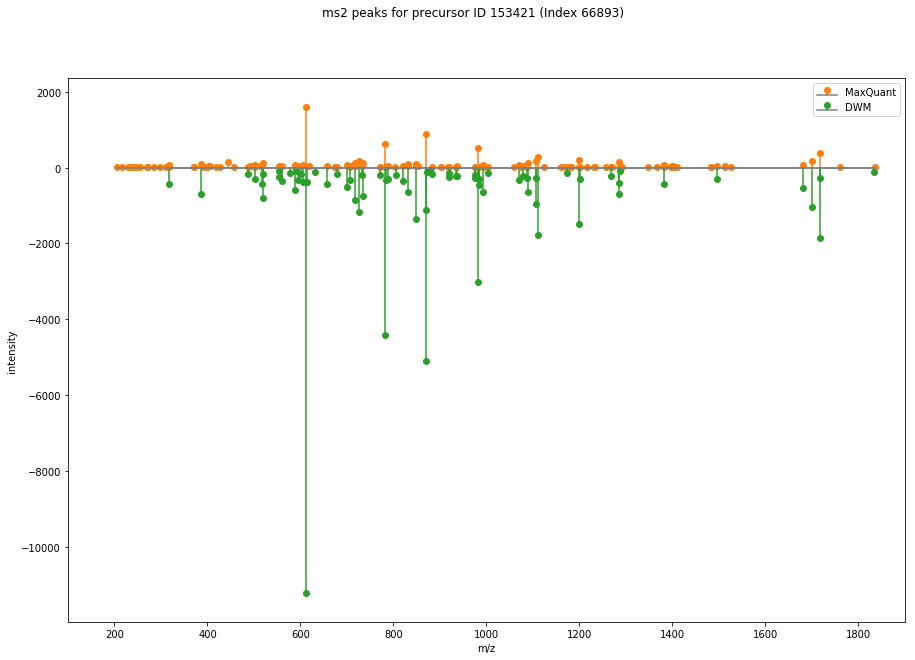

In [396]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(apl_df.mz, apl_df.intensity, 'g', label='MaxQuant')
plt.setp(markerline, 'color', colors[1])
plt.setp(stemlines, 'color', colors[1])
plt.setp(baseline, 'color', colors[7])
markerline, stemlines, baseline = ax.stem(ms2_deconvoluted_peaks_df.m_plus_h, -ms2_deconvoluted_peaks_df.intensity, 'g', label='DWM')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(10)
f.set_figwidth(15)
ax.set_xlim((100,1900))
plt.margins(0.06)
plt.legend(loc='best')
plt.suptitle('ms2 peaks for precursor ID {} (Index {})'.format(precursor_id, msms_scan_number))
plt.show()

### Compare with the real identification from MaxQuant

In [399]:
# check the error from the identification
evidence_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/maxquant_results/txt/evidence.txt', sep='\t')

In [464]:
msms_scan_number

66893

In [466]:
df = evidence_df[evidence_df['MS/MS scan number'] == msms_scan_number]

In [467]:
df.transpose()

,13872
Sequence,GFLNSSELSGLPAGPDR
Length,17
Modifications,Unmodified
Modified sequence,_GFLNSSELSGLPAGPDR_
Oxidation (M) Probabilities,NaN
Oxidation (M) Score Diffs,NaN
Acetyl (Protein N-term),0
Oxidation (M),0
Missed cleavages,0
Proteins,sp|P43897|EFTS_HUMAN;tr|C9JG32|C9JG32_HUMAN;tr...


In [417]:
feature_monoisotopic_mz

859.4455864431093

In [418]:
deconvoluted_peaks_df.iloc[1]

mz                 858.934519
neutral_mass      1715.854484
intensity       359522.000000
score              574.142798
SN               89880.500000
m_plus_h          1716.861784
Name: 1, dtype: float64